# Lab2

## Užduotis

Antroje užduotyje reikia realizuoti vaizdų klasifikavimo modelį.
Atsiskaitinėjant pratybų dėstytojas atsiųs testinių vaizdų, su kuriais turėsite pademonstruoti, kaip jūsų realizuotas modelis veikia.
Atsiskaitymo metu, turėsite gebėti papasakoti, kaip realizuotas, jūsų modelis.
Programinės įrangos sprendimą galite naudoti savo nuožiūra.

- [ ] Klasės pasirenkamos savo nuožiūra, tačiau jų turi būti bent 3.
- [ ] Duomenų rinkinys turi būti padalintas į mokymo ir testavimo aibes.
- [ ] Su testavimo duomenų aibe reikia paskaičiuoti šias metrikas: klasifikavimo matrica (angl. *confusion matrix*), tikslumas, precizija, atkūrimas ir F1.

Duomenų klasėms parinktos iš [OpenImages V6](https://storage.googleapis.com/openimages/web/index.html) objektų aptikimo uždavinio duomenų rinkinio.

## Įgyvendintų papildomų funkcijų papildomi balai $P_2$ pasirinktinai:

- [ ] Palyginimas palyginant aukšto lygio požymius (angl. _similiarity search_)
- [ ] Sukuriant vartotojo sąsają ir modelio iškvietimą per REST API.

### Duomenų atsiuntimas

```{bash}
brew install awscli
```

```{bash}
pipx install oidv6
```
```{bash}
oidv6 downloader --classes Airplane Bus Boat Train --type_data train --no-labels --limit 500 --dest_dir lab2/OIDv6/train
```
```{bash}
oidv6 downloader --classes Airplane Bus Boat Train --type_data test --no-labels --limit 100 --dest_dir lab2/OIDv6/test
```
```{bash}
oidv6 downloader --classes Airplane Bus Boat Train --type_data validation --no-labels --limit 100 --dest_dir lab2/OIDv6/validation
```

In [1]:
# # Resize images in order to decrease training time
# import os
# from PIL import Image

# # Function to resize images in a folder
# def resize_images_in_folder(folder_path):
#     # Get a list of all image files in the folder
#     image_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f)) and f.endswith('.jpg')]

#     # Define the desired size for the resized images
#     desired_size = (128, 128)  # Adjust the size as needed

#     # Iterate over each image file and resize it
#     for image_file in image_files:
#         # Open the image file
#         with Image.open(os.path.join(folder_path, image_file)) as img:
#             # Resize the image
#             resized_img = img.resize(desired_size, resample = Image.LANCZOS)

#             # Overwrite the original image with the resized image
#             resized_img.save(os.path.join(folder_path, image_file))

# # Resize images in specified directories
# directories_to_resize = [
#     "lab2/OIDv6/validation/bus",
#     "lab2/OIDv6/validation/train",
#     "lab2/OIDv6/validation/airplane",
#     "lab2/OIDv6/validation/boat",
#     "lab2/OIDv6/train/bus",
#     "lab2/OIDv6/train/train",
#     "lab2/OIDv6/train/airplane",
#     "lab2/OIDv6/train/boat",
# ]

# for directory in directories_to_resize:
#     resize_images_in_folder(directory)

In [2]:
from pathlib import Path
from typing import Callable
from torch import Tensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from PIL import Image
import torch.optim as optim
from importlib import reload
from copy import deepcopy
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
# Device
import torch

device: torch.device = torch.device('cpu')

if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    print("WARN: Neither MPS nor CUDA device was found.")


In [4]:
DIM = 32
NUM_CHANNELS = 3
NUM_CLASSES = 4

class Net(nn.Module):
	def __init__(self, num_classes = NUM_CLASSES):
		super(Net, self).__init__()
		self.softmax = nn.Softmax()

		self.conv1 = nn.Conv2d(in_channels=NUM_CHANNELS, out_channels=32, kernel_size=3, padding=1)
		self.batchnorm1 = nn.BatchNorm2d(32)
		self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
		self.batchnorm2 = nn.BatchNorm2d(32)
		self.maxpool1 = nn.MaxPool2d(kernel_size=2)
		self.dropout1 = nn.Dropout2d(p=0.2)

		self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
		self.batchnorm3 = nn.BatchNorm2d(64)
		self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
		self.batchnorm4 = nn.BatchNorm2d(64)
		self.maxpool2 = nn.MaxPool2d(kernel_size=2)
		self.dropout2 = nn.Dropout2d(p=0.3)

		self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
		self.batchnorm5 = nn.BatchNorm2d(128)
		self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
		self.batchnorm6 = nn.BatchNorm2d(128)
		self.maxpool3 = nn.MaxPool2d(kernel_size=2)
		self.dropout3 = nn.Dropout2d(p=0.4)

		self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
		self.batchnorm7 = nn.BatchNorm2d(256)
		self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
		self.batchnorm8 = nn.BatchNorm2d(256)
		self.maxpool4 = nn.MaxPool2d(kernel_size=2)
		self.dropout4 = nn.Dropout2d(p=0.45)

		self.flatten = nn.Flatten()
		# self.fc1 = nn.Linear(1024, 256)
		# (2000x1024 and 4096x128)
		self.fc1 = nn.Linear(256 * (DIM // 8) * (DIM // 8), 256)
		self.batchnorm_fc = nn.BatchNorm1d(256)
		self.dropout_fc = nn.Dropout(p=0.5)
		self.fc2 = nn.Linear(256, num_classes)

	def forward(self, x):
		x = torch.relu(self.conv1(x))
		x = self.batchnorm1(x)
		x = torch.relu(self.conv2(x))
		x = self.batchnorm2(x)
		x = self.maxpool1(x)
		x = self.dropout1(x)

		x = torch.relu(self.conv3(x))
		x = self.batchnorm3(x)
		x = torch.relu(self.conv4(x))
		x = self.batchnorm4(x)
		x = self.maxpool2(x)
		x = self.dropout2(x)

		x = torch.relu(self.conv5(x))
		x = self.batchnorm5(x)
		x = torch.relu(self.conv6(x))
		x = self.batchnorm6(x)
		x = self.maxpool3(x)
		x = self.dropout3(x)

		x = torch.relu(self.conv7(x))
		x = self.batchnorm7(x)
		x = torch.relu(self.conv8(x))
		x = self.batchnorm8(x)
		x = self.maxpool4(x)
		x = self.dropout4(x)

		x = self.flatten(x)
		x = torch.relu(self.fc1(x))
		x = self.batchnorm_fc(x)
		x = self.dropout_fc(x)
		x = self.fc2(x)

		return x

In [5]:
model = Net(num_classes = NUM_CLASSES).to(device)

In [6]:
import lab2.trans
reload(lab2.trans)
from lab2.trans import train_trans, validation_trans, test_trans

In [7]:
train_ds      = ImageFolder("lab2/OIDv6/train",      transform = train_trans)
validation_ds = ImageFolder("lab2/OIDv6/validation", transform = validation_trans)
test_ds       = ImageFolder("lab2/OIDv6/test",       transform = test_trans)

In [8]:
BATCH_SIZE = 2048
train_dl      = DataLoader(train_ds,      shuffle = True,  batch_size = BATCH_SIZE, num_workers = 16)
validation_dl = DataLoader(validation_ds, shuffle = False, batch_size = BATCH_SIZE, num_workers = 16)
test_dl       = DataLoader(test_ds,       shuffle = False, batch_size = BATCH_SIZE, num_workers = 16)

/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [9]:
LEARNING_RATE = 0.0005
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)

/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


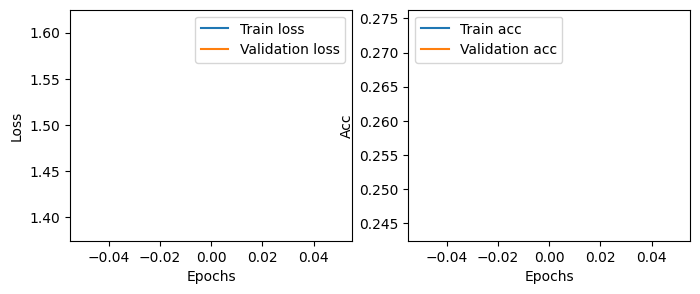

Epoch [1/90] [32.63 secs] [Total time: 1 mins]


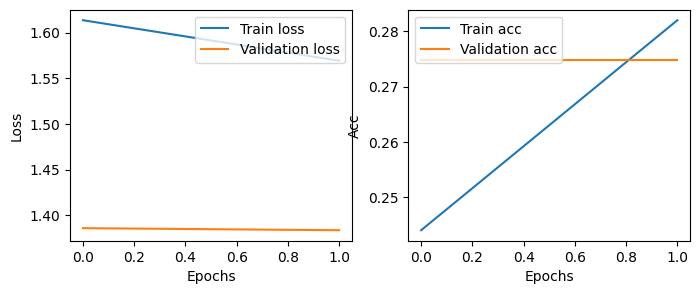

Epoch [2/90] [34.26 secs] [Total time: 1 mins]


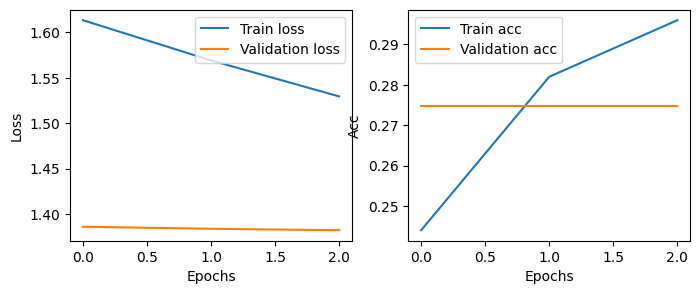

Epoch [3/90] [31.73 secs] [Total time: 2 mins]


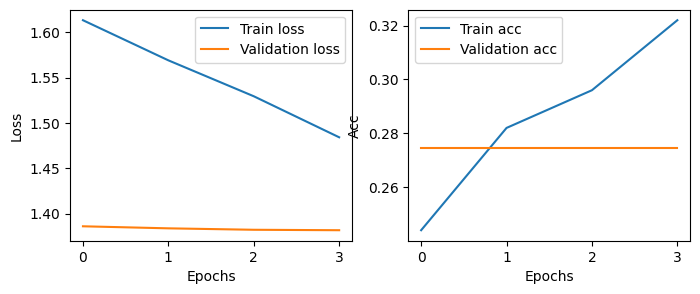

Epoch [4/90] [31.05 secs] [Total time: 2 mins]


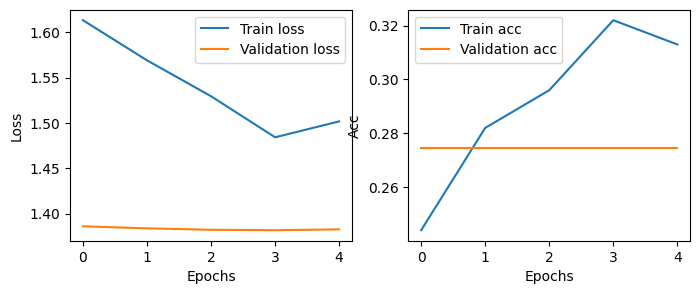

Epoch [5/90] [31.08 secs] [Total time: 3 mins]


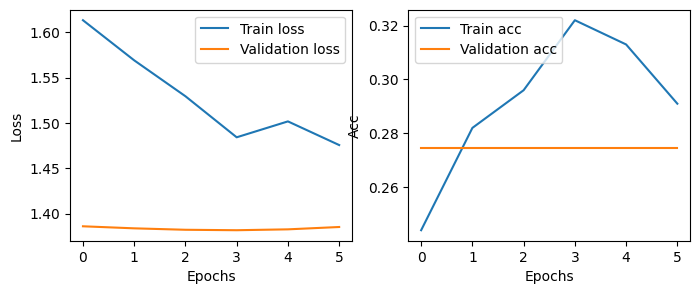

Epoch [6/90] [31.41 secs] [Total time: 3 mins]


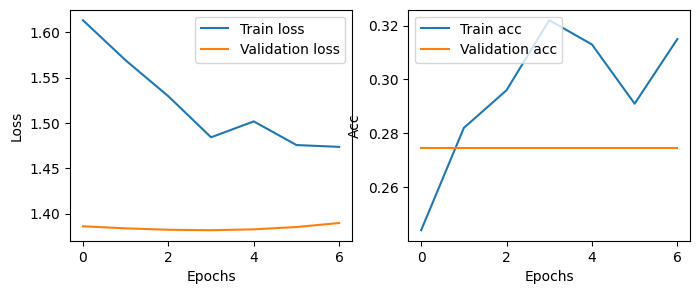

Epoch [7/90] [31.68 secs] [Total time: 4 mins]


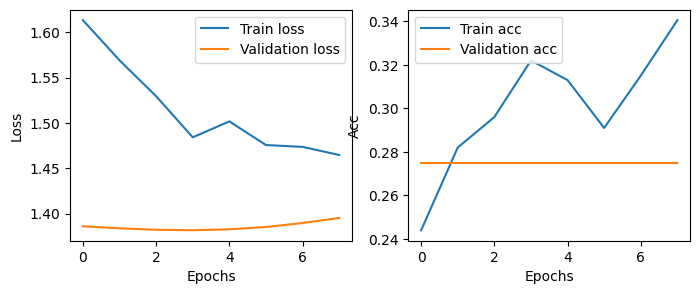

Epoch [8/90] [31.44 secs] [Total time: 4 mins]


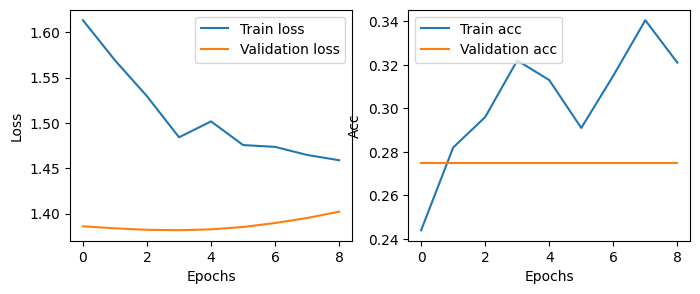

Epoch [9/90] [31.83 secs] [Total time: 5 mins]


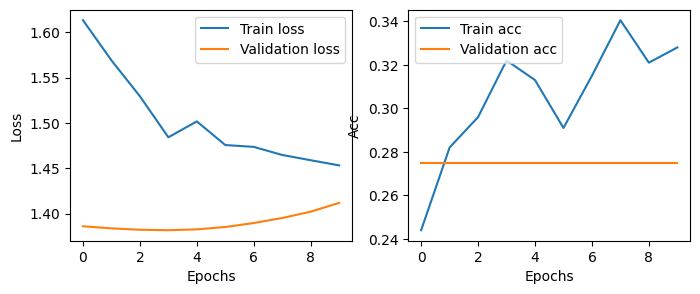

Epoch [10/90] [31.42 secs] [Total time: 5 mins]


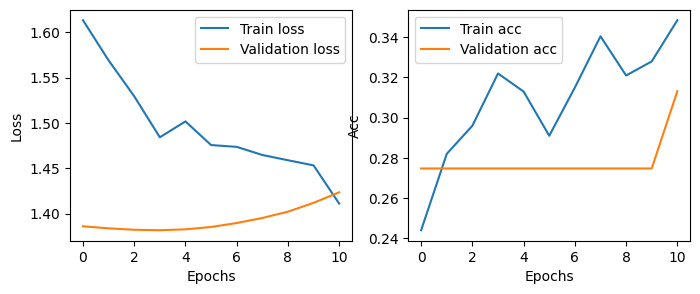

Epoch [11/90] [31.44 secs] [Total time: 6 mins]


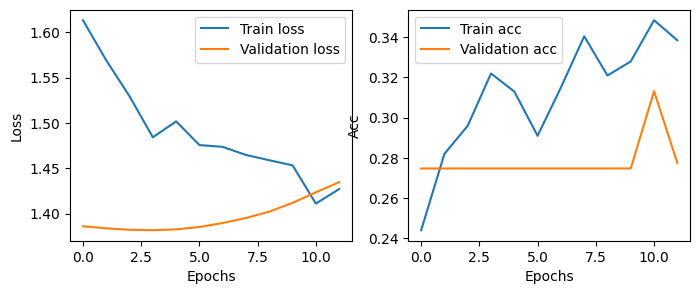

Epoch [12/90] [31.07 secs] [Total time: 6 mins]


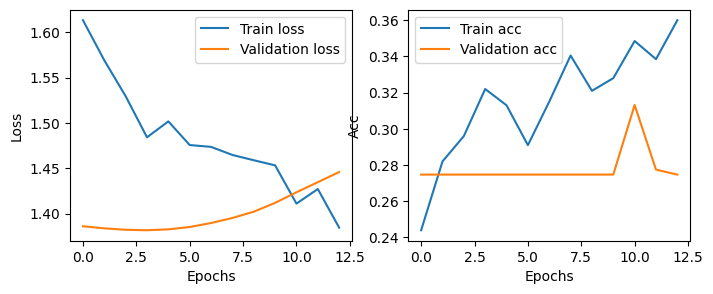

Epoch [13/90] [33.11 secs] [Total time: 7 mins]


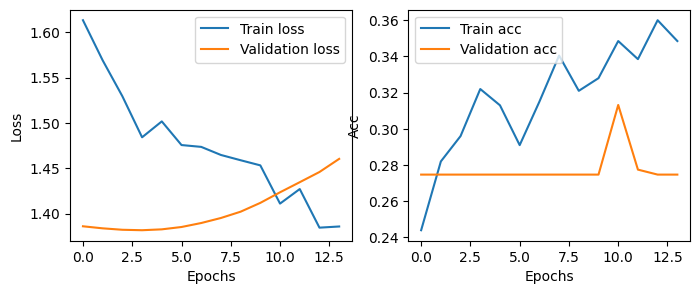

Epoch [14/90] [33.50 secs] [Total time: 7 mins]


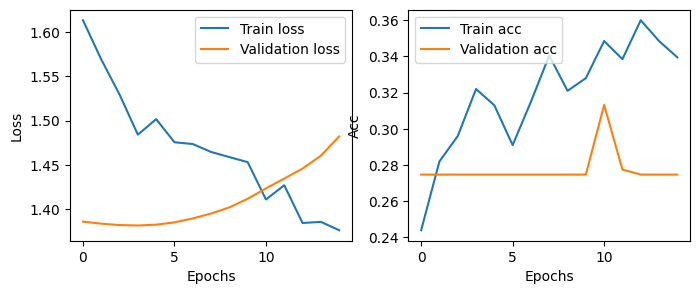

Epoch [15/90] [33.68 secs] [Total time: 8 mins]


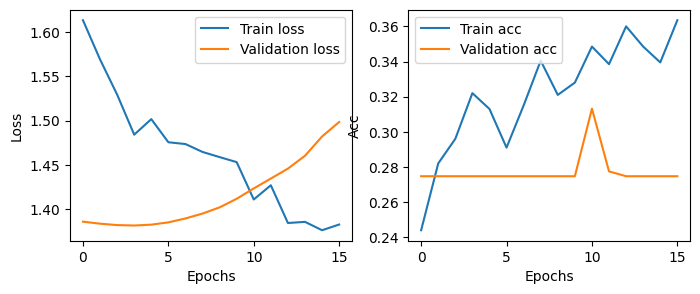

Epoch [16/90] [33.59 secs] [Total time: 9 mins]


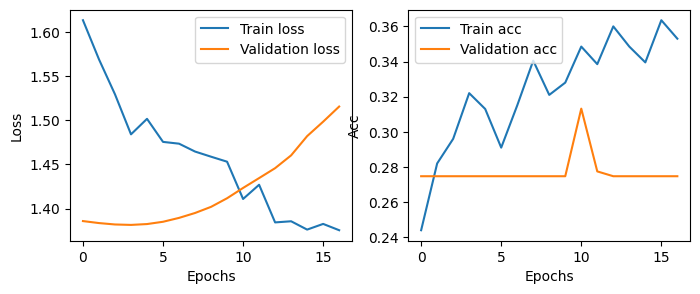

Epoch [17/90] [32.91 secs] [Total time: 9 mins]


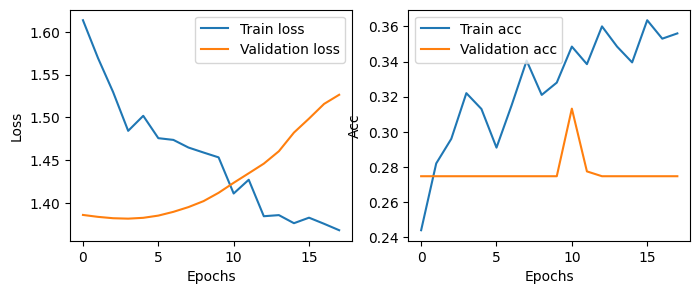

Epoch [18/90] [31.29 secs] [Total time: 10 mins]


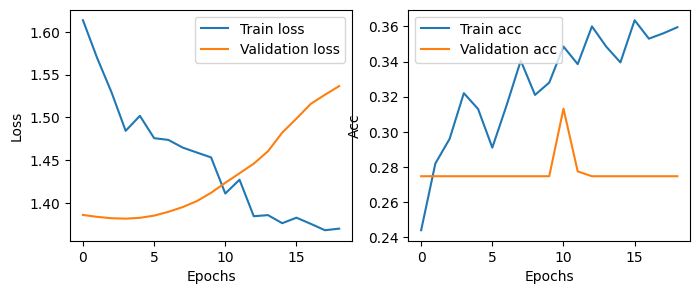

Epoch [19/90] [31.44 secs] [Total time: 10 mins]


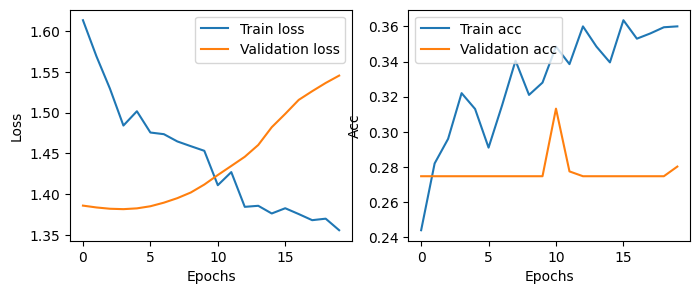

Epoch [20/90] [30.97 secs] [Total time: 11 mins]


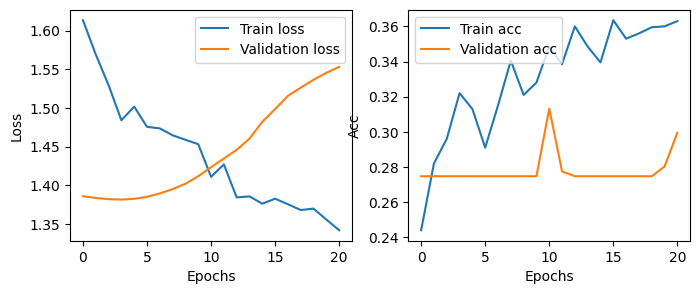

Epoch [21/90] [31.57 secs] [Total time: 11 mins]


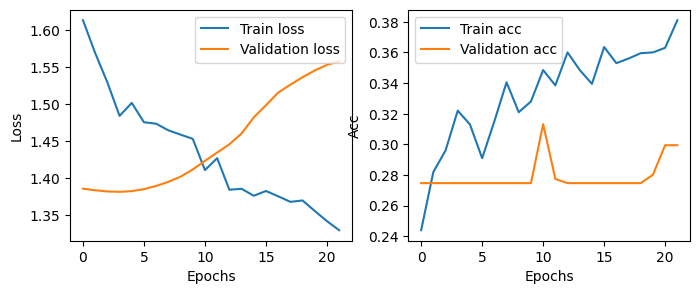

Epoch [22/90] [195.79 secs] [Total time: 14 mins]


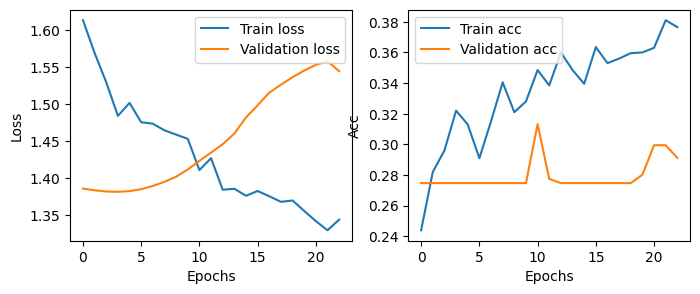

Epoch [23/90] [84.16 secs] [Total time: 16 mins]


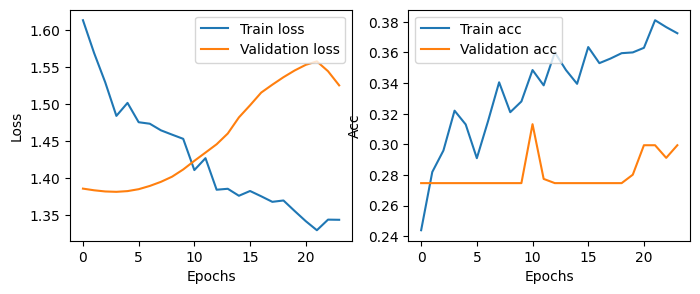

Epoch [24/90] [1139.02 secs] [Total time: 35 mins]


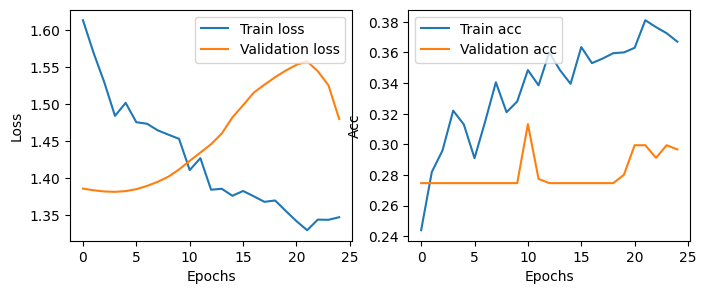

Epoch [25/90] [143.88 secs] [Total time: 37 mins]


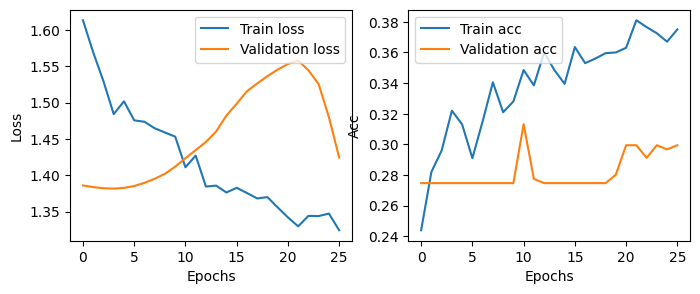

Epoch [26/90] [1927.80 secs] [Total time: 69 mins]


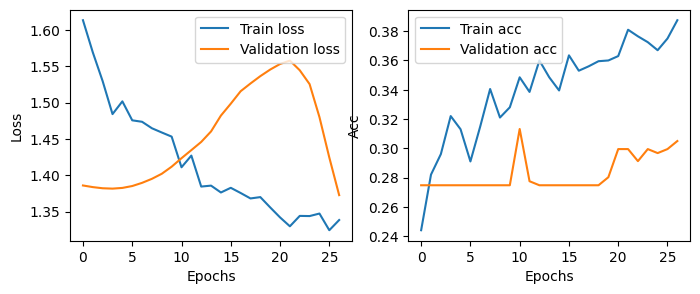

Epoch [27/90] [31.20 secs] [Total time: 70 mins]


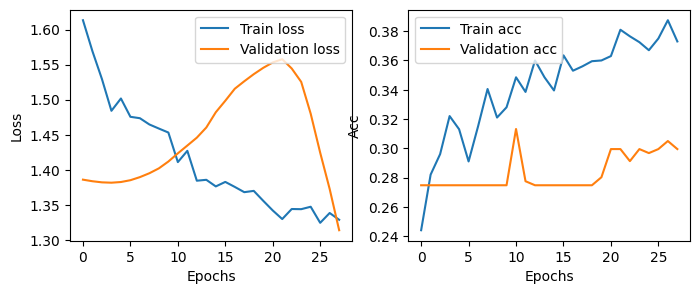

Epoch [28/90] [24.02 secs] [Total time: 70 mins]


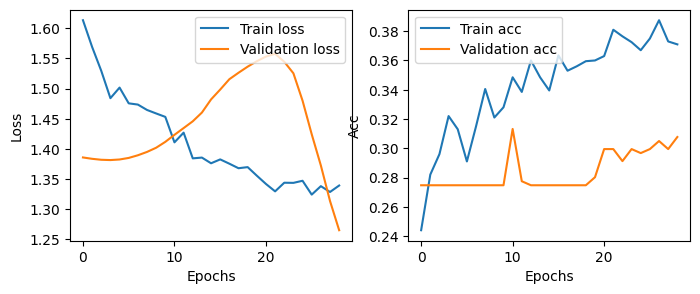

Epoch [29/90] [24.01 secs] [Total time: 71 mins]


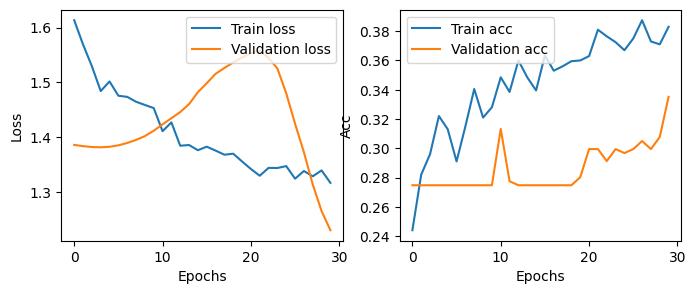

Epoch [30/90] [23.27 secs] [Total time: 71 mins]


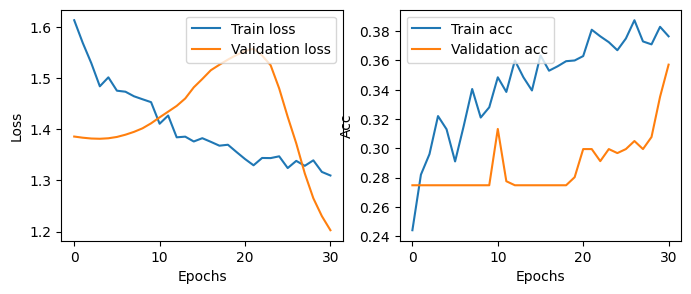

Epoch [31/90] [23.28 secs] [Total time: 71 mins]


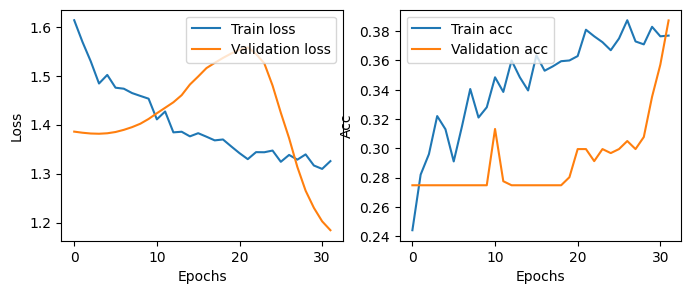

Epoch [32/90] [23.59 secs] [Total time: 72 mins]


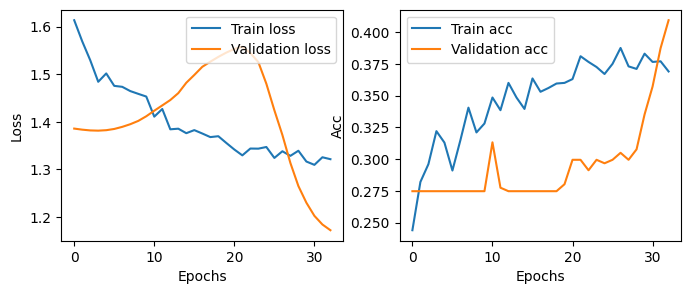

Epoch [33/90] [24.63 secs] [Total time: 72 mins]


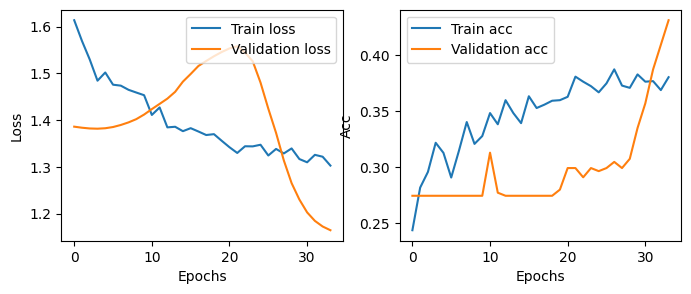

Epoch [34/90] [23.47 secs] [Total time: 73 mins]


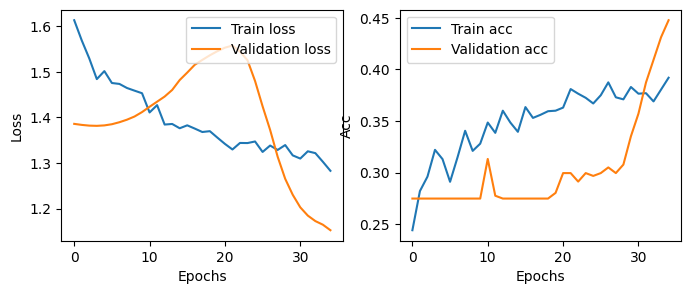

Epoch [35/90] [23.10 secs] [Total time: 73 mins]


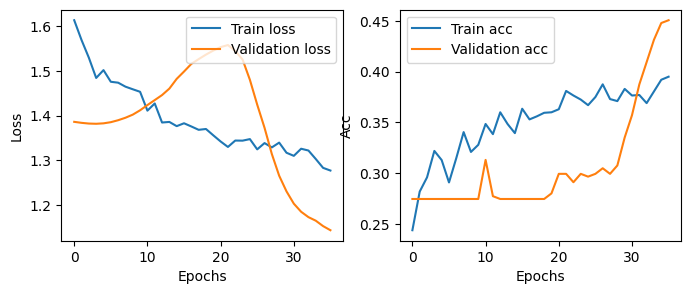

Epoch [36/90] [22.87 secs] [Total time: 73 mins]


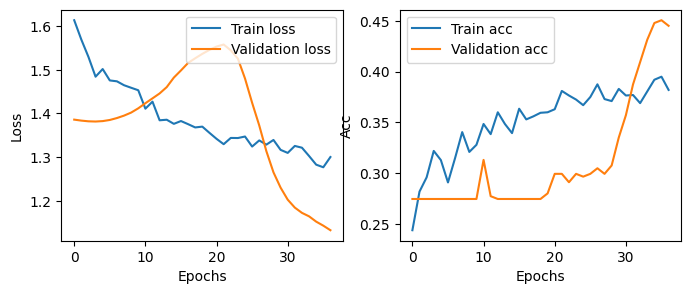

Epoch [37/90] [24.94 secs] [Total time: 74 mins]


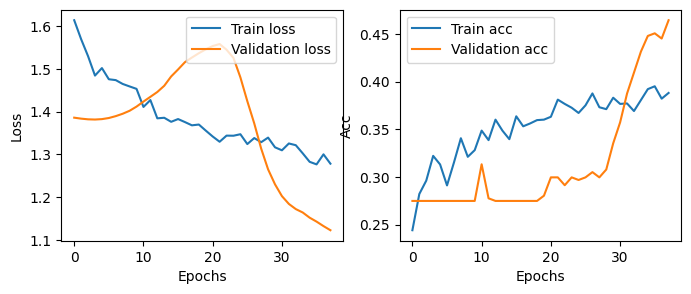

Epoch [38/90] [23.83 secs] [Total time: 74 mins]


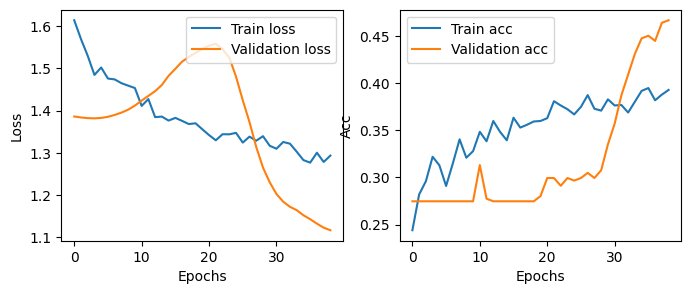

Epoch [39/90] [23.26 secs] [Total time: 75 mins]


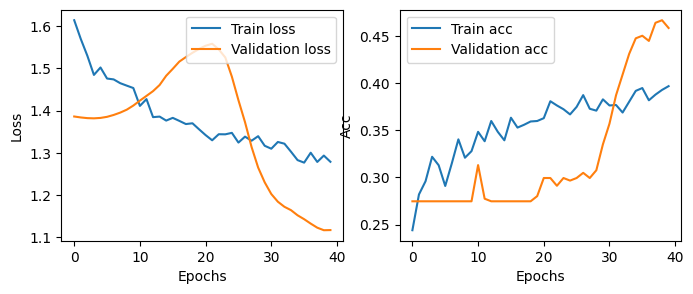

Epoch [40/90] [23.94 secs] [Total time: 75 mins]


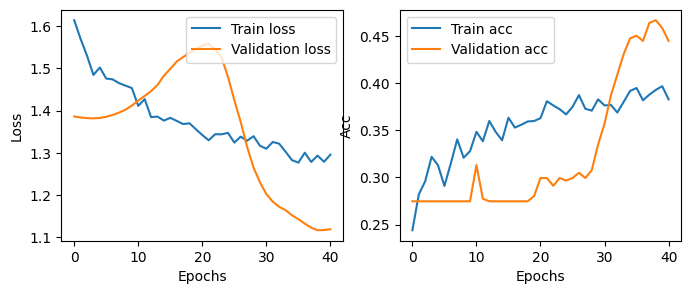

Epoch [41/90] [24.94 secs] [Total time: 75 mins]


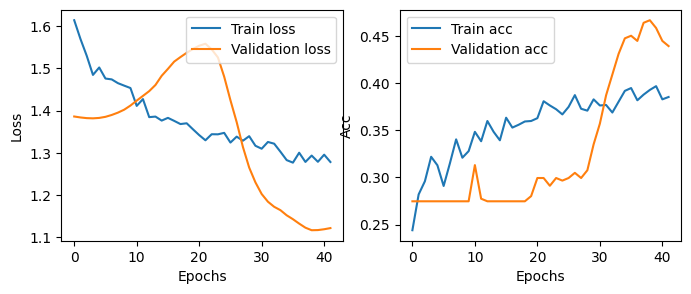

Epoch [42/90] [24.26 secs] [Total time: 76 mins]


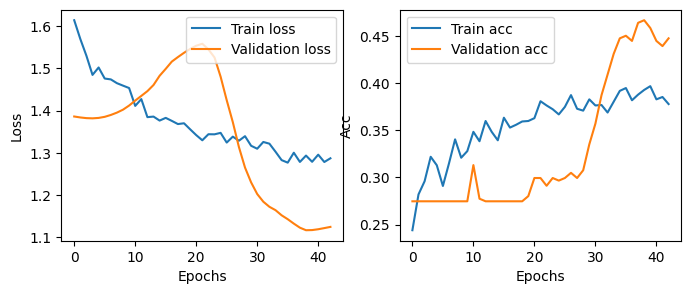

Epoch [43/90] [23.59 secs] [Total time: 76 mins]


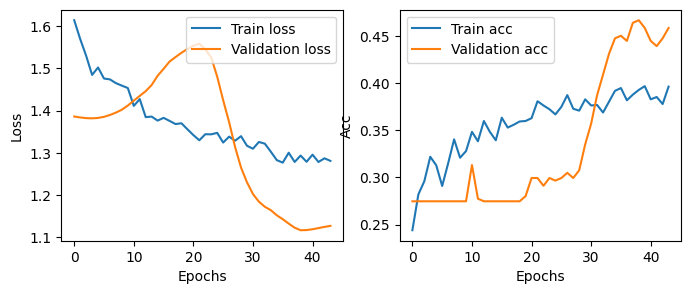

Epoch [44/90] [23.77 secs] [Total time: 77 mins]


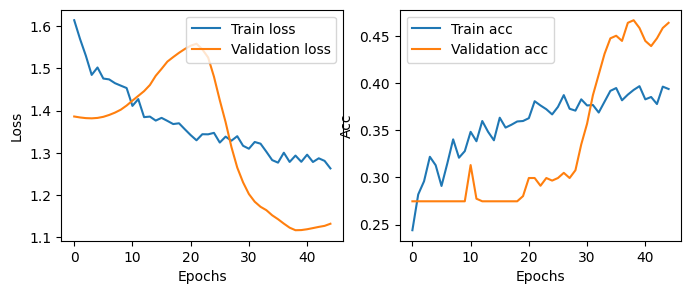

Epoch [45/90] [23.45 secs] [Total time: 77 mins]


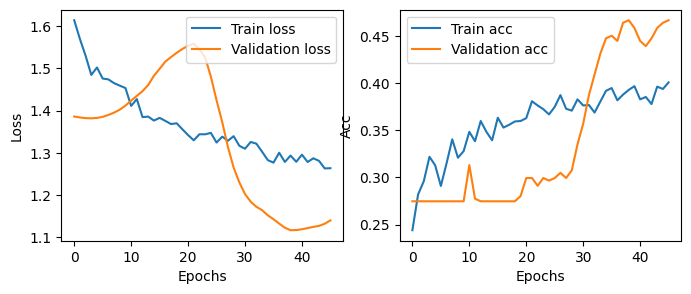

Epoch [46/90] [23.11 secs] [Total time: 77 mins]


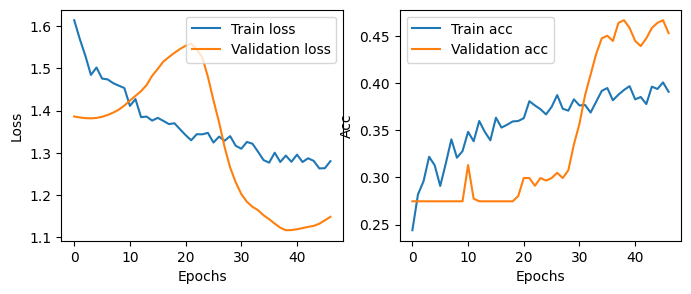

Epoch [47/90] [23.50 secs] [Total time: 78 mins]


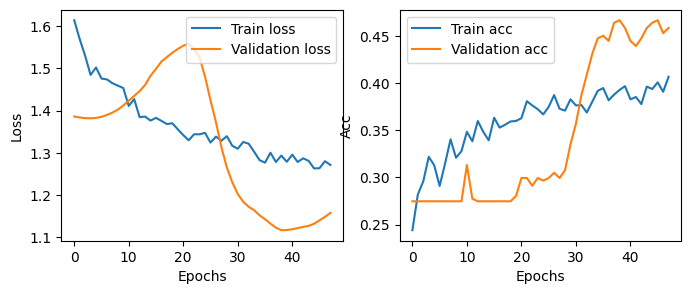

Epoch [48/90] [23.46 secs] [Total time: 78 mins]


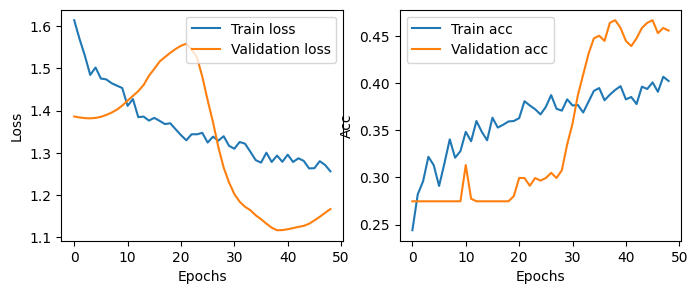

Epoch [49/90] [23.35 secs] [Total time: 79 mins]


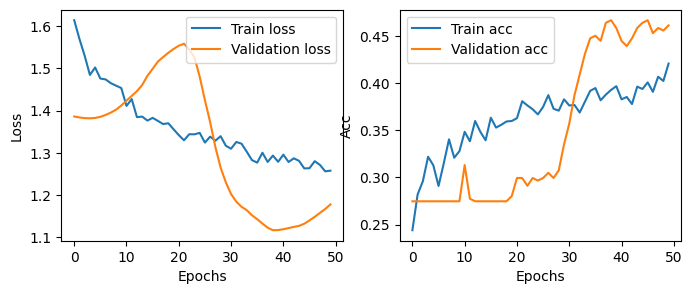

Epoch [50/90] [23.37 secs] [Total time: 79 mins]


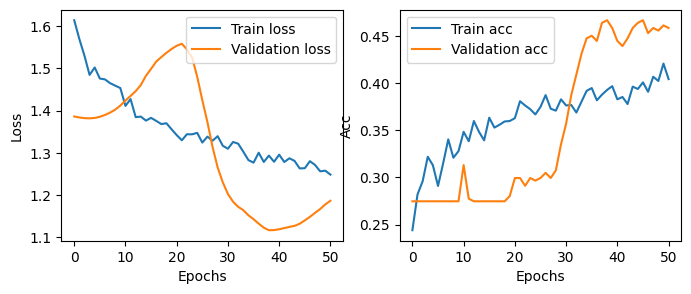

Epoch [51/90] [23.27 secs] [Total time: 79 mins]


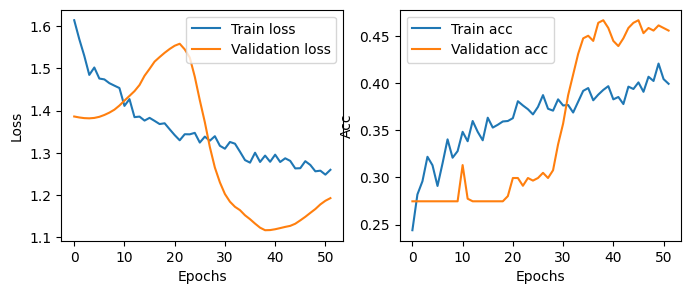

Epoch [52/90] [23.67 secs] [Total time: 80 mins]


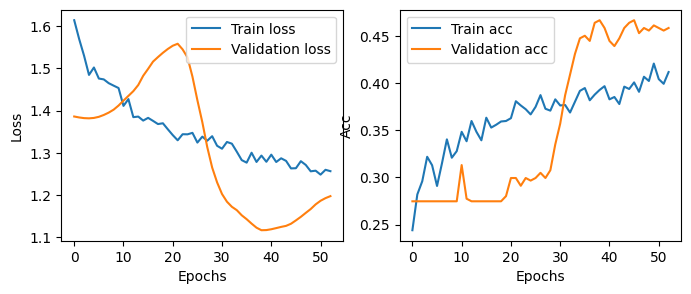

Epoch [53/90] [24.08 secs] [Total time: 80 mins]


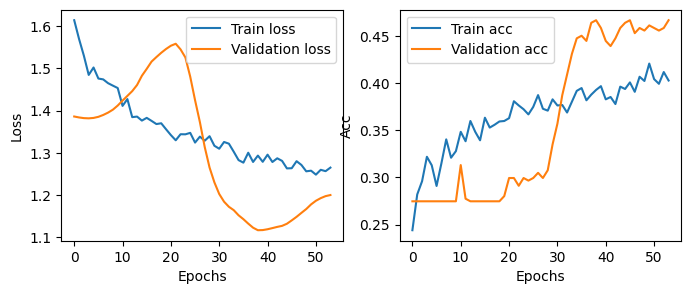

Epoch [54/90] [23.39 secs] [Total time: 81 mins]


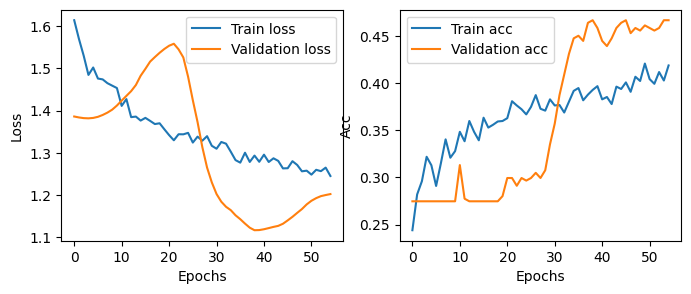

Epoch [55/90] [23.40 secs] [Total time: 81 mins]


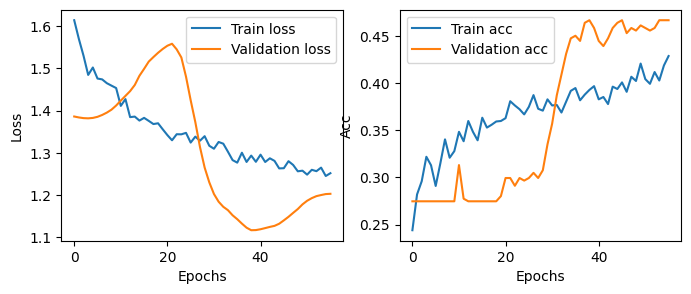

Epoch [56/90] [23.67 secs] [Total time: 81 mins]


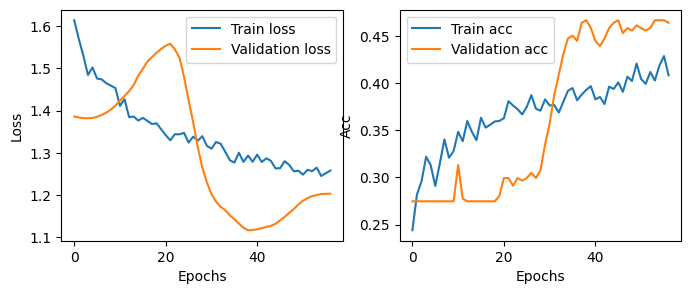

Epoch [57/90] [23.23 secs] [Total time: 82 mins]


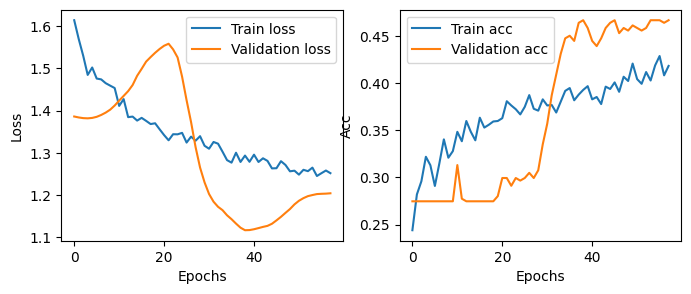

Epoch [58/90] [23.56 secs] [Total time: 82 mins]


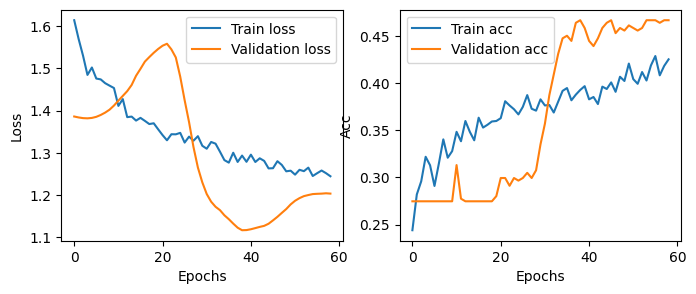

Epoch [59/90] [23.56 secs] [Total time: 83 mins]


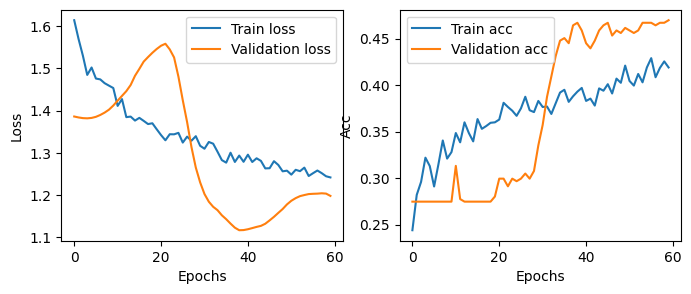

Epoch [60/90] [23.50 secs] [Total time: 83 mins]


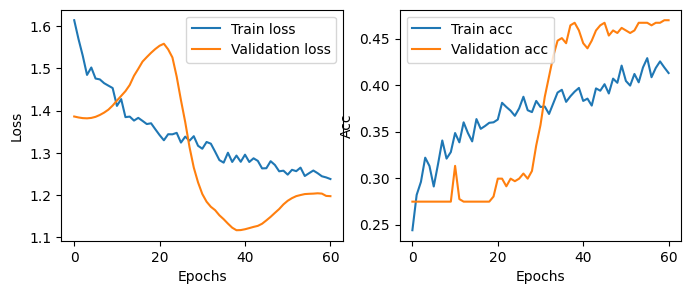

Epoch [61/90] [23.98 secs] [Total time: 83 mins]


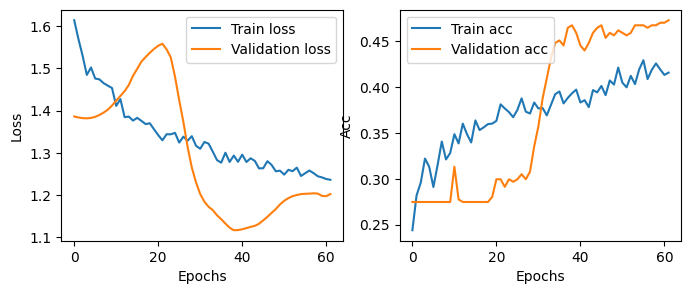

Epoch [62/90] [23.88 secs] [Total time: 84 mins]


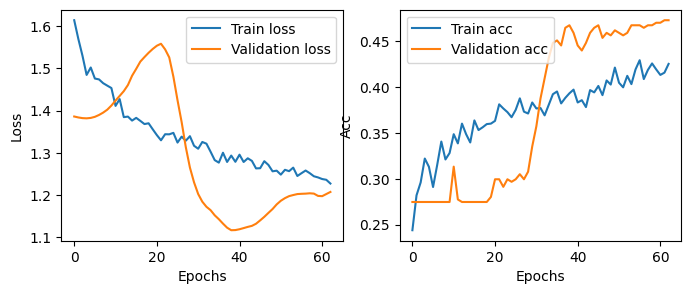

Epoch [63/90] [23.80 secs] [Total time: 84 mins]


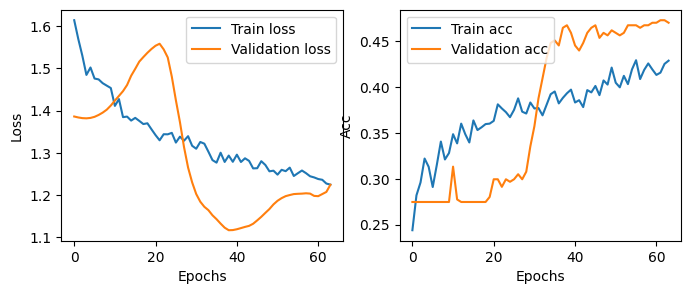

Epoch [64/90] [23.55 secs] [Total time: 85 mins]


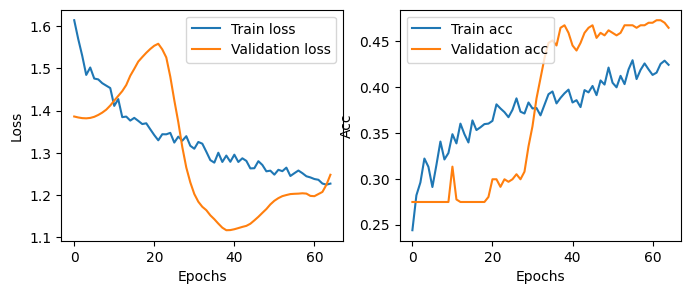

Epoch [65/90] [23.75 secs] [Total time: 85 mins]


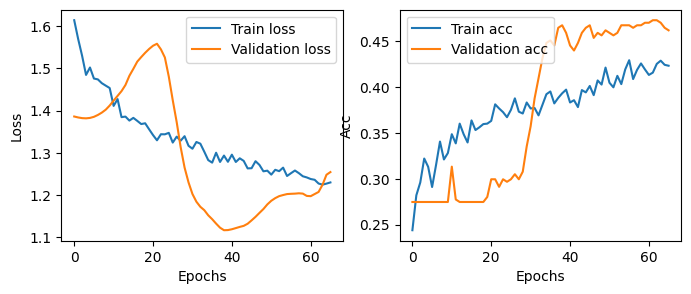

Epoch [66/90] [23.30 secs] [Total time: 85 mins]


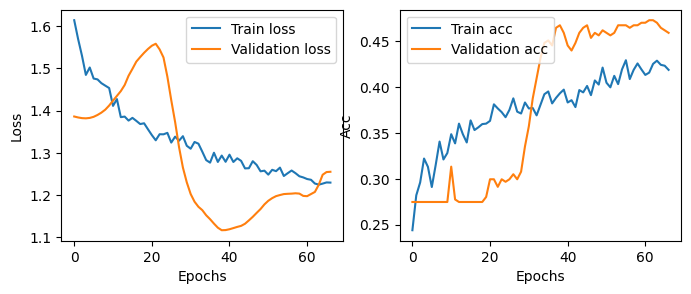

Epoch [67/90] [23.69 secs] [Total time: 86 mins]


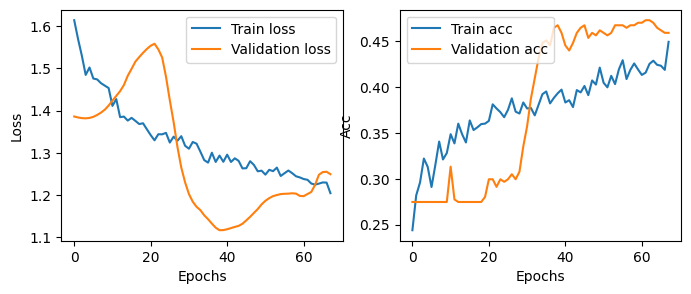

Epoch [68/90] [23.20 secs] [Total time: 86 mins]


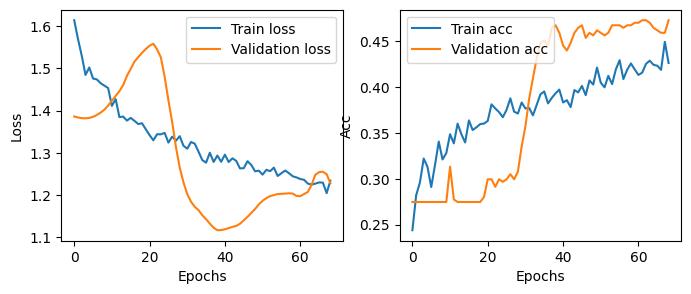

Epoch [69/90] [23.14 secs] [Total time: 86 mins]


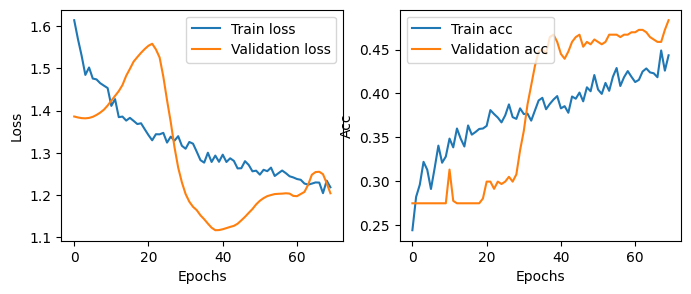

Epoch [70/90] [23.57 secs] [Total time: 87 mins]


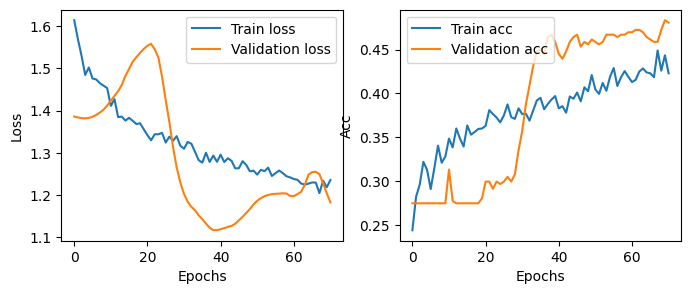

Epoch [71/90] [23.56 secs] [Total time: 87 mins]


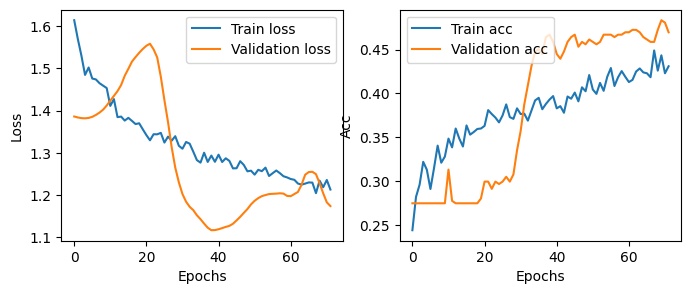

Epoch [72/90] [23.43 secs] [Total time: 88 mins]


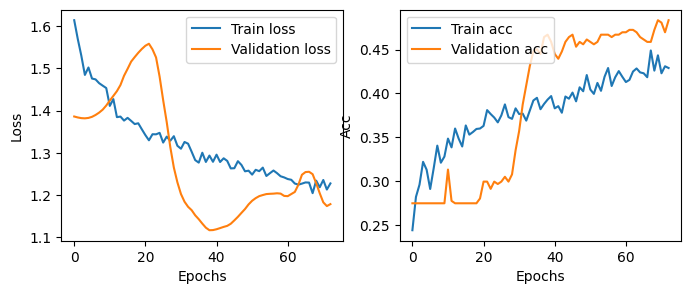

Epoch [73/90] [23.29 secs] [Total time: 88 mins]


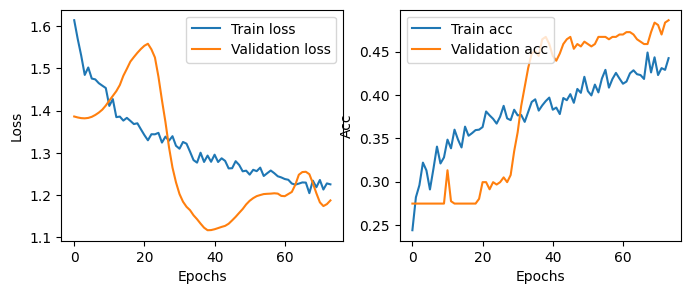

Epoch [74/90] [23.11 secs] [Total time: 88 mins]


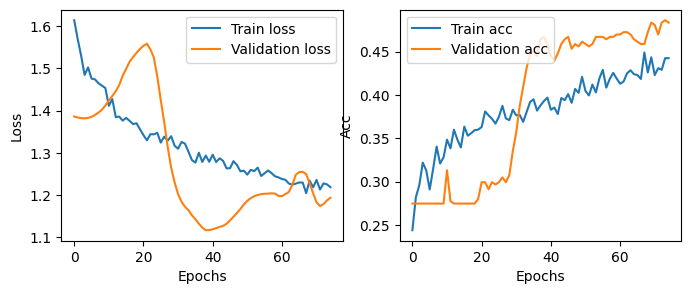

Epoch [75/90] [23.22 secs] [Total time: 89 mins]


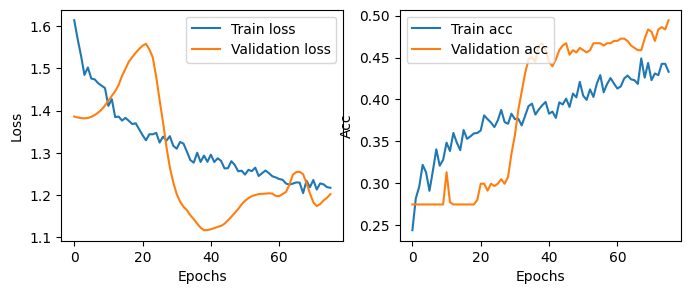

Epoch [76/90] [23.32 secs] [Total time: 89 mins]


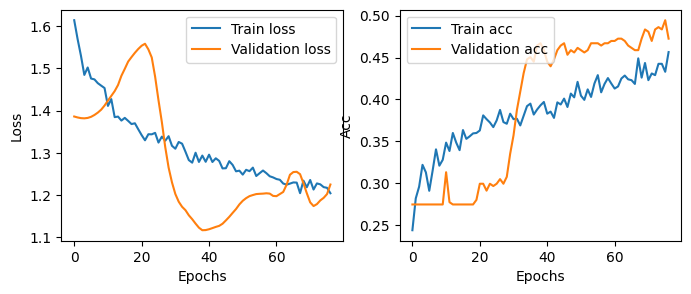

Epoch [77/90] [23.08 secs] [Total time: 90 mins]


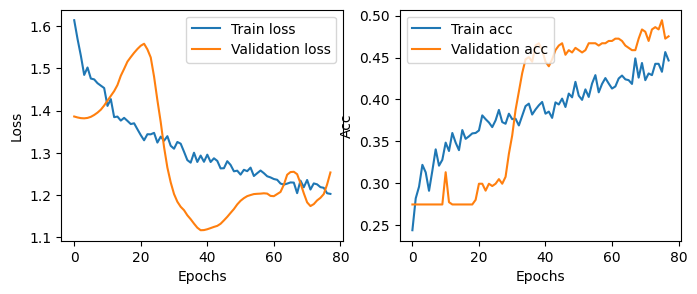

Epoch [78/90] [24.45 secs] [Total time: 90 mins]


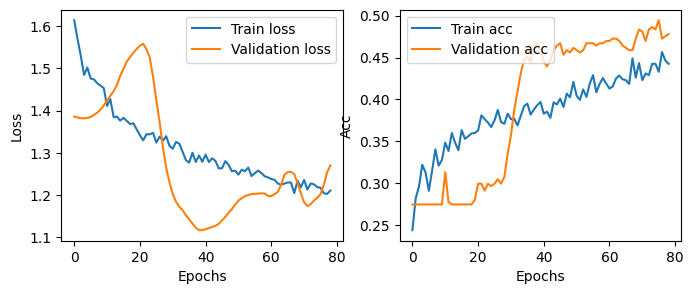

Epoch [79/90] [23.92 secs] [Total time: 90 mins]


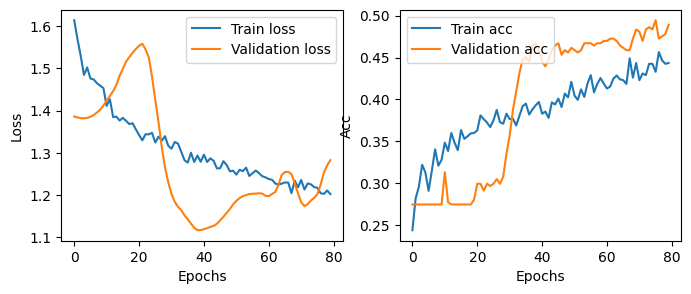

Epoch [80/90] [23.45 secs] [Total time: 91 mins]


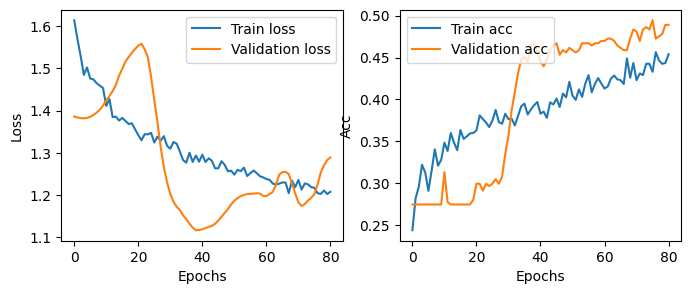

Epoch [81/90] [23.53 secs] [Total time: 91 mins]


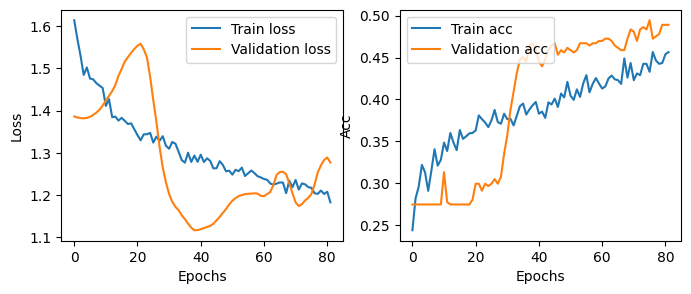

Epoch [82/90] [25.23 secs] [Total time: 92 mins]


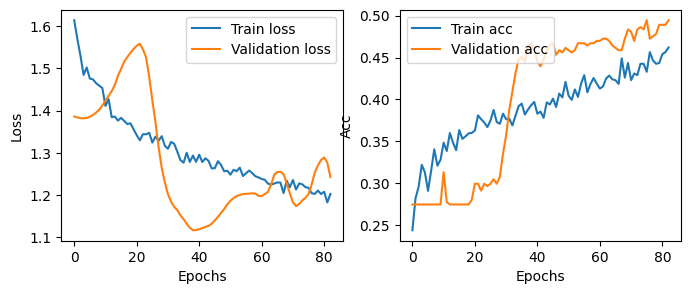

Epoch [83/90] [27.54 secs] [Total time: 92 mins]


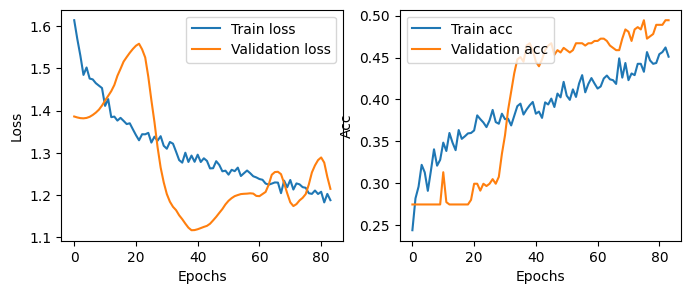

Epoch [84/90] [24.34 secs] [Total time: 92 mins]


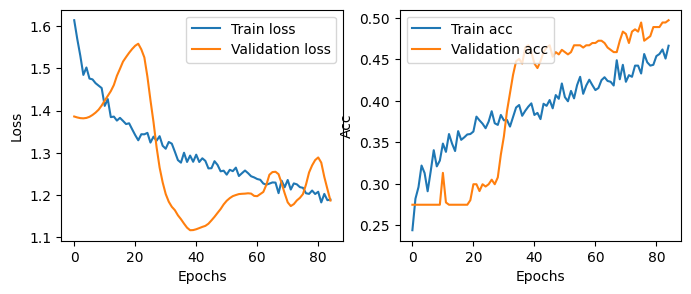

Epoch [85/90] [25.59 secs] [Total time: 93 mins]


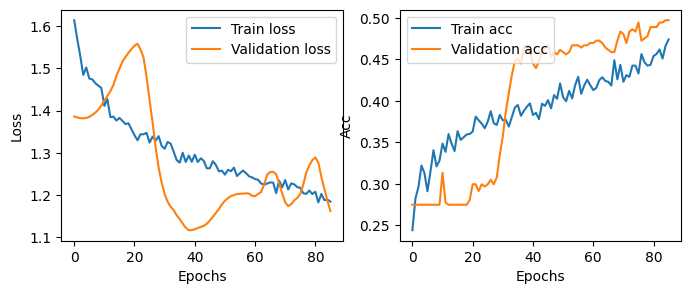

Epoch [86/90] [25.10 secs] [Total time: 93 mins]


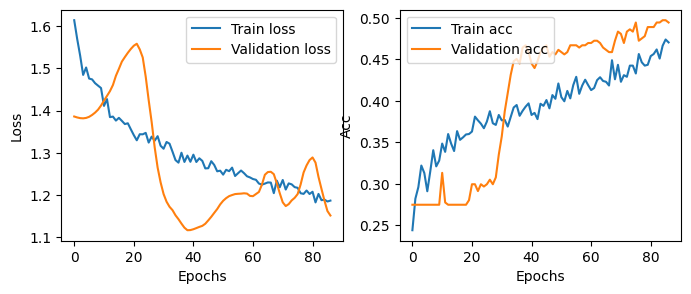

Epoch [87/90] [24.95 secs] [Total time: 94 mins]


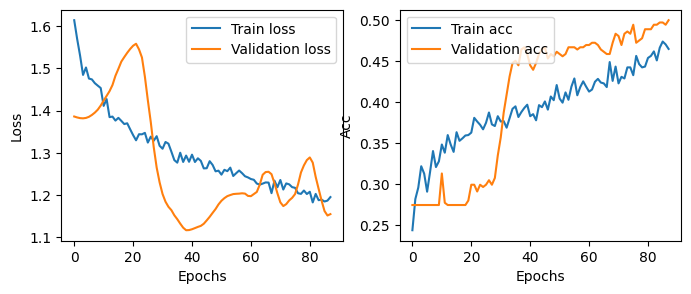

Epoch [88/90] [24.99 secs] [Total time: 94 mins]


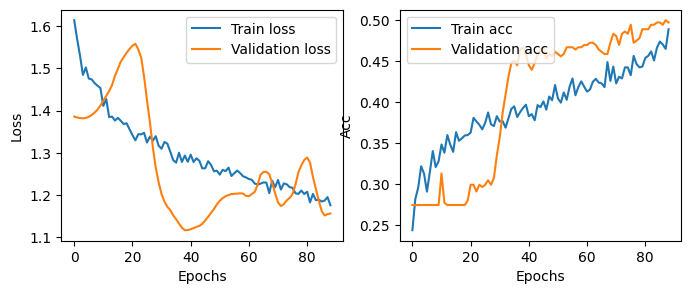

Epoch [89/90] [25.02 secs] [Total time: 95 mins]


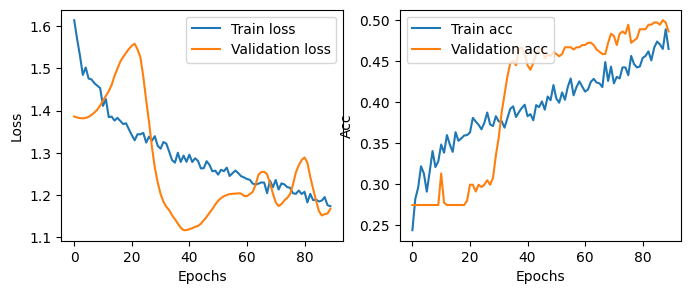

Epoch [90/90] [24.88 secs] [Total time: 95 mins]


In [10]:
from torch import cat as c
from torch import tensor as t

import time

import lab2.graphs
reload(lab2.graphs)
from lab2.graphs import display_loss, display_acc

train_history = {
  'ls': torch.zeros(0),
  'ys': torch.zeros(0, 0),
  'y_hats': torch.zeros(0, 0)
}; th = train_history

validation_history = {
  'ls': torch.zeros(0),
  'ys': torch.zeros(0, 0),
  'y_hats': torch.zeros(0, 0)
}; vh = validation_history

NUM_EPOCHS = 90
VALIDATE = True

softmax = nn.Softmax()
start_time = time.time()
time_ = start_time

for epoch in range(NUM_EPOCHS):
  model.train()

  l = t([])
  y = t([])
  y_hat = t([])
  ix = -1
  for inputs, labels in train_dl:
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    optimizer.zero_grad()

    y =     c((y, labels.detach().cpu().to("cpu")), dim = -1)
    y_hat = c((y_hat, softmax(outputs).argmax(dim = -1).detach().cpu().to("cpu")), dim = -1)
    l = c((l, loss.cpu().detach().to("cpu").reshape(1)))

    if ix == 0:
      break
    ix -= 1

  # print(f"  l_shape {l.shape}")
  # print(f"  y_shape {y.shape}")
  # print(f"  ys_shape {th['ys'].shape}")
  
  th['ls'] = c((th['ls'], torch.mean(l).unsqueeze(0)))
  th['ys'] = c((th['ys'].reshape(-1, y.shape[0]), y.unsqueeze(0)))
  th['y_hats'] = c((th['y_hats'].reshape(-1, y.shape[0]), y_hat.unsqueeze(0)))

  if VALIDATE:
    l = t([])
    y = t([])
    y_hat = t([])
    model.eval()
    with torch.no_grad():
      for inputs, labels in validation_dl:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        y =     c((y, labels.detach().cpu().to("cpu")), dim = -1)
        y_hat = c((y_hat, softmax(outputs).argmax(dim = -1).detach().cpu().to("cpu")), dim = -1)
        l = c((l, loss.cpu().detach().to("cpu").reshape(1)))
  
    vh['ls']     = c((vh['ls'], torch.mean(l).unsqueeze(0)))
    vh['ys']     = c((vh['ys'].reshape(-1, y.shape[0]), y.unsqueeze(0)))
    vh['y_hats'] = c((vh['y_hats'].reshape(-1, y.shape[0]), y_hat.unsqueeze(0)))

  plt.close()
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize= (8, 3))
  display_loss(ax1, train_history, label = 'Train loss')
  display_acc(ax2, train_history, label = 'Train acc')

  if VALIDATE:
    display_loss(ax1, validation_history, label = 'Validation loss')
    display_acc(ax2, validation_history, label = 'Validation acc')

  plt.pause(0.1)
  print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] [{time.time() - start_time:.2f} secs] [Total time: {(time.time() - time_) / 60 :.0f} mins]")
  start_time = time.time()


In [11]:
test_history = {
  'ls': torch.zeros(0),
  'ys': torch.zeros(0, 0),
  'y_hats': torch.zeros(0,0)
}; test_history


y = t([])
y_hat = t([])
model.eval()
with torch.no_grad():
  for inputs, labels in test_dl:
    inputs, labels = inputs.to(device), labels.to(device)

    outputs = model(inputs)

    y     = c((y, labels.detach().cpu().to("cpu")), dim = -1)
    y_hat = c((y_hat, softmax(outputs).argmax(dim = -1).detach().cpu().to("cpu")), dim = -1)


/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 8 (`cpuset` is not taken into account), which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/Users/domantelio/Projects/gmm/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1511: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


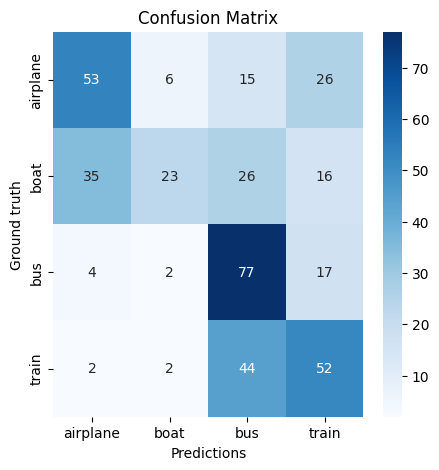

              precision    recall  f1-score   support

    airplane       0.56      0.53      0.55       100
        boat       0.70      0.23      0.35       100
         bus       0.48      0.77      0.59       100
       train       0.47      0.52      0.49       100

    accuracy                           0.51       400
   macro avg       0.55      0.51      0.49       400
weighted avg       0.55      0.51      0.49       400



In [12]:
from sklearn.metrics import confusion_matrix, classification_report

import seaborn as sns

conf_matrix = confusion_matrix(y, y_hat)
class_names = test_ds.classes

plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, cmap="Blues", fmt="d", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predictions')
plt.ylabel('Ground truth')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y, y_hat, target_names=class_names))

In [13]:
torch.save(model.state_dict(), "lab2.pth")